In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 17:25:13 2016

@author: tabacof
"""

# Implements a variational autoencoder as described in Kingma et al. 2013
# "Auto-Encoding Variational Bayes"
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
import numpy as np
import lasagne
import time, shutil, os
import scipy
from scipy.io import loadmat
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import pylab as plt
from read_write_model import read_model, write_model

Using gpu device 1: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:
#settings
do_train_model = False
batch_size = 100
num_epochs = 50
model_filename = "mnist_clf"

np.random.seed(1234) # reproducibility

In [3]:
print "Using MNIST dataset"

from keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x = (train_x.reshape((-1, 784))/255.0).astype(np.float32)
test_x = (test_x.reshape((-1, 784))/255.0).astype(np.float32)

input_var = T.matrix('inputs')
target_var = T.ivector('targets')

Using MNIST dataset


Using Theano backend.


In [4]:
relu = lasagne.nonlinearities.rectify

network = lasagne.layers.InputLayer(shape=(None, 784),input_var=input_var)
l_noise = lasagne.layers.BiasLayer(network, b = np.zeros((784,), dtype = np.float32), shared_axes = 0, name = "NOISE")
l_noise.params[l_noise.b].remove("trainable")
network = lasagne.layers.DenseLayer(l_noise, num_units=1024, nonlinearity=relu)
network = lasagne.layers.dropout(network, p=.5)
network = lasagne.layers.DenseLayer(network, num_units=1024, nonlinearity=relu)
network = lasagne.layers.dropout(network, p=.5)
network = lasagne.layers.DenseLayer(network, num_units=10, nonlinearity=lasagne.nonlinearities.softmax)

In [5]:
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, 0.01, 0.9)

test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

train_fn = theano.function([input_var, target_var], loss, updates=updates)

val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

In [6]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [7]:
if do_train_model:
    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(train_x, train_y, batch_size, shuffle=True):
            tr_inputs, tr_targets = batch
            train_err += train_fn(tr_inputs, tr_targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(test_x, test_y, batch_size, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))
    write_model([network], model_filename)
else:
    read_model([network], model_filename)

Starting training...
Epoch 1 of 50 took 2.779s
  training loss:		0.479064
  validation loss:		0.191972
  validation accuracy:		94.37 %
Epoch 2 of 50 took 2.824s
  training loss:		0.219869
  validation loss:		0.133617
  validation accuracy:		95.92 %
Epoch 3 of 50 took 2.750s
  training loss:		0.168053
  validation loss:		0.107457
  validation accuracy:		96.73 %
Epoch 4 of 50 took 3.229s
  training loss:		0.136328
  validation loss:		0.096986
  validation accuracy:		96.93 %
Epoch 5 of 50 took 3.237s
  training loss:		0.116115
  validation loss:		0.084837
  validation accuracy:		97.30 %
Epoch 6 of 50 took 2.905s
  training loss:		0.103301
  validation loss:		0.077774
  validation accuracy:		97.45 %
Epoch 7 of 50 took 2.777s
  training loss:		0.091582
  validation loss:		0.074523
  validation accuracy:		97.53 %
Epoch 8 of 50 took 2.851s
  training loss:		0.081317
  validation loss:		0.068561
  validation accuracy:		97.86 %
Epoch 9 of 50 took 3.417s
  training loss:		0.075238
  validation l

In [8]:
def show_mnist(img, i, title=""): # expects flattened image of shape (3072,) 
    img = img.copy().reshape(28, 28)
    img = np.clip(img, 0, 1)
    plt.subplot(3, 2, i)
    plt.imshow(img, cmap='Greys_r')
    plt.title(title)
    plt.axis("off")

In [9]:
# Adversarial confusion cost function
adv_confusion = lasagne.objectives.categorical_crossentropy(test_prediction, target_var).mean()

# Adversarial regularization
regC = T.scalar()
adv_reg = regC*lasagne.regularization.l2(l_noise.b)
# Total adversarial loss
adv_loss = adv_confusion + adv_reg
adv_grad = T.grad(adv_loss, l_noise.b)

# Function used to optimize the adversarial noise
adv_function = theano.function([input_var, target_var, regC], [adv_loss, adv_grad, test_prediction])

In [10]:
def adv_test(orig_img, adv_label, C, plot = True):
    # Set the adversarial noise to zero
    l_noise.b.set_value(np.zeros((784,)).astype(np.float32))

    _, _, orig_pred = adv_function(test_x[orig_img][np.newaxis, :], [adv_label], C)

    # Initialize the adversarial noise for the optimization procedure
    l_noise.b.set_value(np.random.uniform(-1e-8, 1e-8, size=(784,)).astype(np.float32))

    # Optimization function for L-BFGS-B
    def fmin_func(x):
        l_noise.b.set_value(x.astype(np.float32))
        f, g, _ = adv_function(test_x[orig_img][np.newaxis, :], [adv_label], C)
        return float(f), g.flatten().astype(np.float64)

    # Noise bounds (pixels cannot exceed 0-1)
    bounds = zip(-test_x[orig_img], 1-test_x[orig_img])

    # L-BFGS-B optimization to find adversarial noise
    x, f, d = scipy.optimize.fmin_l_bfgs_b(fmin_func, l_noise.b.get_value().flatten(), bounds = bounds, fprime = None, factr = 10, m = 25)
    l_noise.b.set_value(x.astype(np.float32))
    
    adv_loss, _, adv_pred = adv_function(test_x[orig_img][np.newaxis, :], [adv_label], C)

    if plot:
        plt.figure()
        show_mnist(test_x[orig_img], 1, "Original")
        show_mnist(test_x[orig_img] + x, 2, "Adversarial")
        plt.show()

    return adv_loss, np.linalg.norm(x), test_y[orig_img], np.argmax(orig_pred), np.argmax(adv_pred), adv_pred[0][test_y[orig_img]], adv_pred[0][adv_label]

In [14]:
def orig_adv_dist(orig_img = None, plot = False):
    if orig_img is None:
        orig_img = np.random.randint(0, len(test_x))
        _, _, pred = adv_function(test_x[orig_img][np.newaxis, :], [0], 0.0)
        print(np.argmax(pred), test_y[orig_img], pred)
        while np.argmax(pred) != test_y[orig_img]:
            orig_img = np.random.randint(0, len(test_x))
            _, _, pred = adv_function(test_x[orig_img][np.newaxis, :], [0], 0.0)
            print(np.argmax(pred), test_y[orig_img], pred)

    adv_label = test_y[orig_img]
    while adv_label ==  test_y[orig_img]:
        adv_label = np.random.randint(0, 10)
        
    print "Img",orig_img, "Adv label", adv_label
    
    adv_loss=[]
    adv_norm=[]
    orig_prob=[]
    adv_prob=[]
    adv = []
    
    C = np.logspace(-10, 20, 50, base = 2, dtype = np.float32)
    
    for c in C:
        od, ad, ol, op, ap, o_prob, a_prob = adv_test(orig_img, adv_label, C=c, plot = False)
        #print od, ad, ol+1, op+1, ap+1
        adv_loss.append(od)
        adv_norm.append(ad)
        adv.append(ap == adv_label)
        orig_prob.append(o_prob)
        adv_prob.append(a_prob)
        
    adv_loss = np.array(adv_loss)
    adv_norm = np.array(adv_norm)

    if plot:
        plt.figure()
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [adv_loss[i] for i, x in enumerate(adv) if x], c='red', label = "Adversarial")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [adv_loss[i] for i, x in enumerate(adv) if not x], c='blue', label = "Non-adversarial")
        plt.ylabel("Adversarial cross-entropy")
        plt.xlabel("Adversarial distortion")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        plt.figure()
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [adv_prob[i] for i, x in enumerate(adv) if x], c='orange', label = "Adversarial Adv")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [adv_prob[i] for i, x in enumerate(adv) if not x], c='cyan', label = "Non-adversarial Adv")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [orig_prob[i] for i, x in enumerate(adv) if x], c='red', label = "Adversarial Orig")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [orig_prob[i] for i, x in enumerate(adv) if not x], c='blue', label = "Non-adversarial Orig")
        plt.ylabel("Probability")
        plt.xlabel("Adversarial distortion")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        plt.figure()
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [scipy.special.logit(adv_prob[i]) for i, x in enumerate(adv) if x], c='orange', label = "Adversarial Adv")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [scipy.special.logit(adv_prob[i]) for i, x in enumerate(adv) if not x], c='cyan', label = "Non-adversarial Adv")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [scipy.special.logit(orig_prob[i]) for i, x in enumerate(adv) if x], c='red', label = "Adversarial Orig")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [scipy.special.logit(orig_prob[i]) for i, x in enumerate(adv) if not x], c='blue', label = "Non-adversarial Orig")
        plt.ylabel("Logit")
        plt.xlabel("Adversarial distortion")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        
    return adv_norm, adv_loss, adv_prob, orig_prob

(5, 5, array([[  1.23600557e-07,   2.96446229e-10,   5.60267943e-11,
          2.93986968e-09,   9.21317189e-12,   9.99999881e-01,
          5.43600649e-08,   7.41120443e-10,   4.02940579e-08,
          9.56904972e-11]], dtype=float32))
Img 8132 Adv label 4


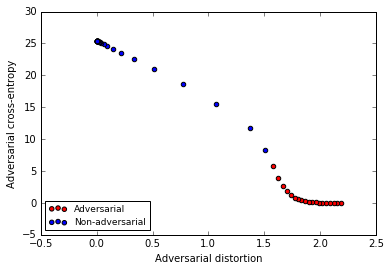

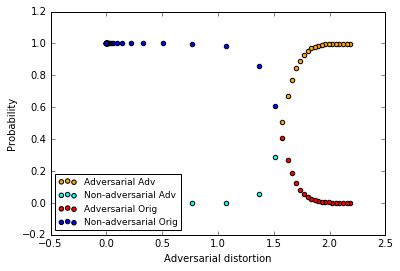

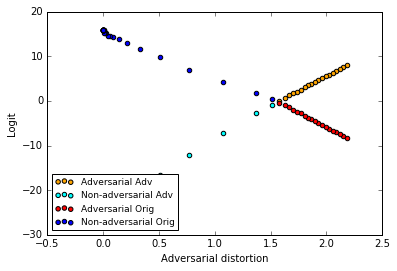

(6, 6, array([[  4.42829717e-10,   5.56203738e-12,   2.75045785e-12,
          2.59019558e-13,   3.05937740e-11,   2.09404494e-10,
          1.00000000e+00,   1.13711641e-14,   9.08302530e-11,
          2.57324916e-14]], dtype=float32))
Img 6094 Adv label 1


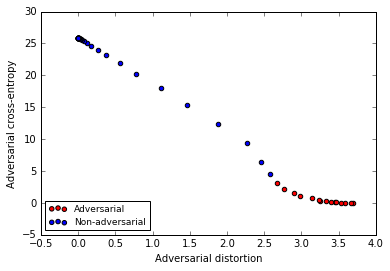

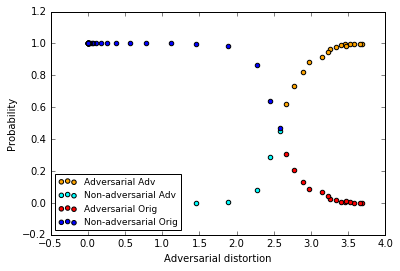

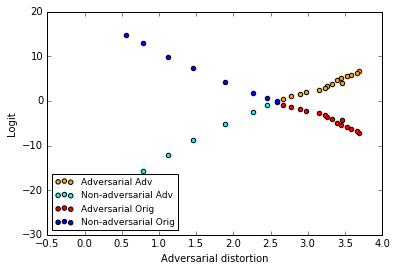

(3, 3, array([[  1.80205070e-11,   4.01137928e-10,   5.83626480e-10,
          9.99685943e-01,   1.74056585e-11,   4.71794119e-05,
          3.06458113e-14,   1.05302700e-09,   5.26443849e-08,
          2.66767107e-04]], dtype=float32))
Img 8254 Adv label 7


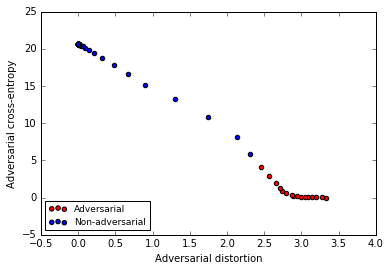

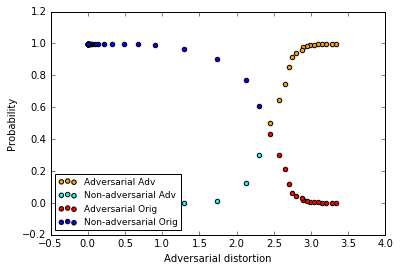

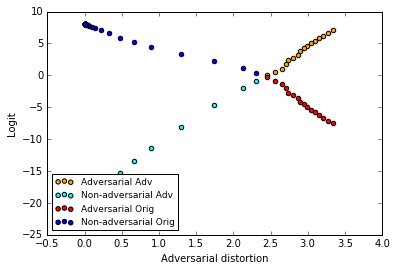

(1, 1, array([[  3.06462161e-10,   9.99984741e-01,   1.73669257e-08,
          2.27160138e-10,   3.76556898e-07,   1.18329277e-10,
          3.24847771e-09,   1.47944402e-05,   1.30106358e-07,
          1.52662692e-11]], dtype=float32))
Img 4732 Adv label 7


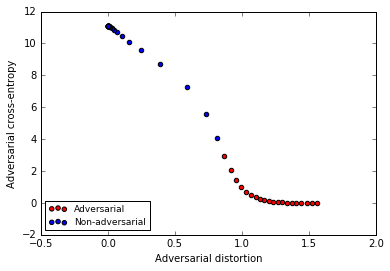

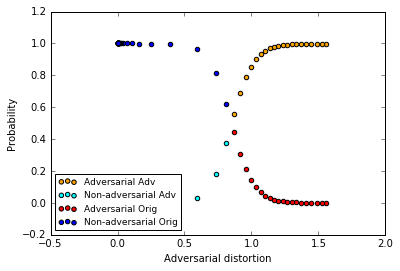

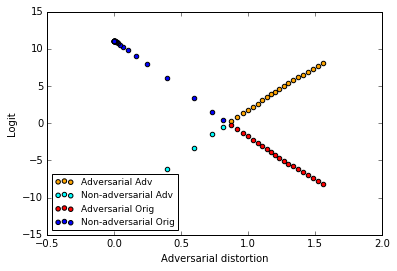

(3, 3, array([[  1.65740340e-16,   4.02614790e-12,   1.60441955e-11,
          1.00000000e+00,   1.73859865e-14,   2.66956643e-08,
          2.39611890e-17,   4.74263369e-13,   1.79818688e-10,
          7.87481469e-10]], dtype=float32))
Img 2840 Adv label 8


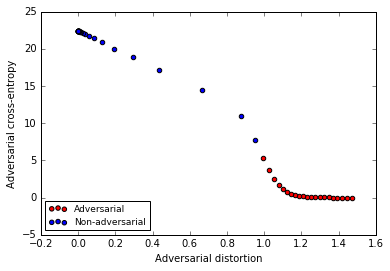

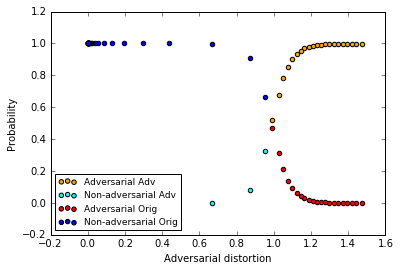

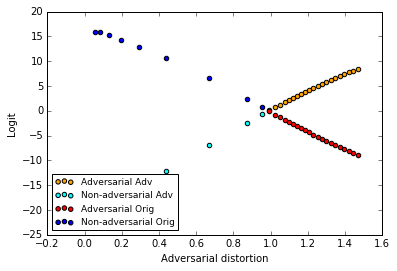

(5, 5, array([[  1.21840607e-15,   2.02364899e-13,   9.45694485e-17,
          4.45227712e-08,   3.63201110e-18,   1.00000000e+00,
          9.61188269e-13,   2.26811071e-17,   9.43175833e-12,
          9.60215241e-10]], dtype=float32))
Img 2282 Adv label 0


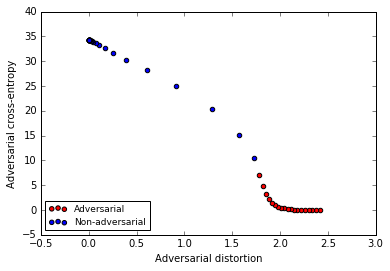

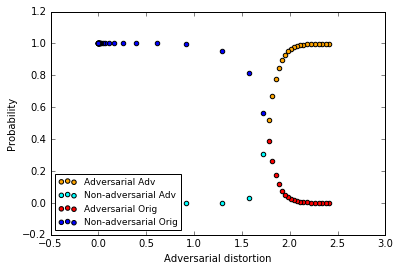

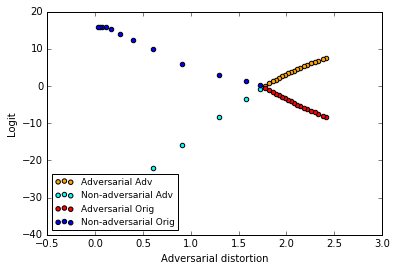

(2, 2, array([[  7.70083552e-10,   2.02149222e-05,   9.99977112e-01,
          1.92756957e-07,   2.90923136e-11,   3.26880012e-09,
          1.92185947e-08,   2.29431976e-06,   1.78238935e-07,
          1.16924595e-11]], dtype=float32))
Img 1184 Adv label 6


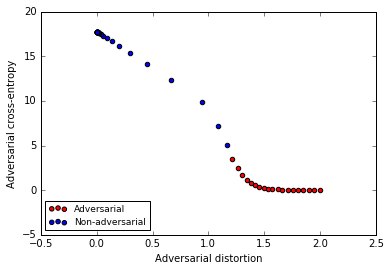

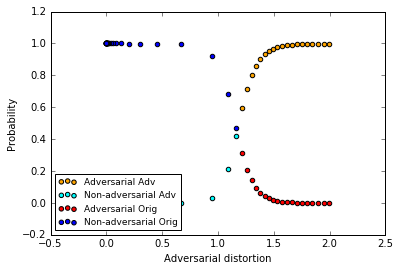

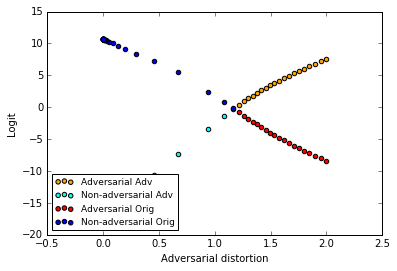

(3, 3, array([[  2.05309330e-19,   7.91070117e-13,   9.24141406e-15,
          1.00000000e+00,   3.02901294e-20,   3.58642217e-12,
          3.48434970e-20,   1.92170583e-14,   5.77777713e-12,
          1.96072705e-13]], dtype=float32))
Img 5492 Adv label 1


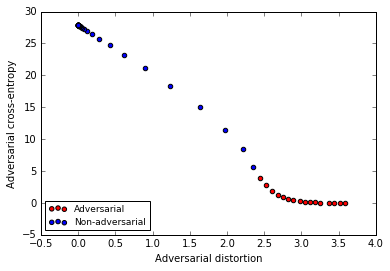

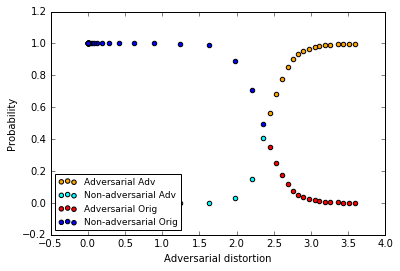

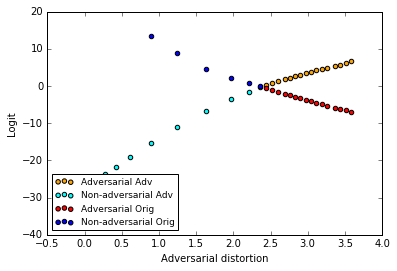

(4, 4, array([[  1.69438266e-11,   1.76231339e-07,   1.19279719e-09,
          3.96118871e-09,   9.99999642e-01,   1.42947348e-10,
          7.16932347e-11,   2.94985525e-09,   1.31295946e-10,
          1.31517439e-07]], dtype=float32))
Img 4221 Adv label 2


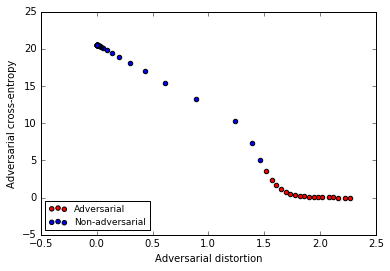

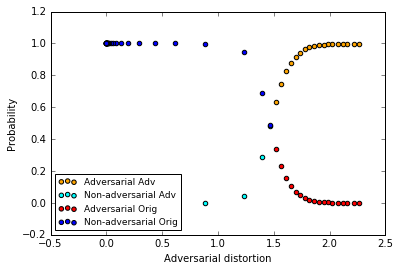

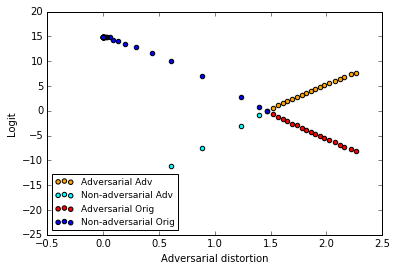

(4, 4, array([[  6.29964555e-16,   1.27362487e-09,   7.99307035e-16,
          3.02997746e-15,   1.00000000e+00,   5.51660361e-14,
          1.26149579e-13,   1.44230872e-09,   1.68739297e-14,
          9.96210614e-11]], dtype=float32))
Img 6931 Adv label 1


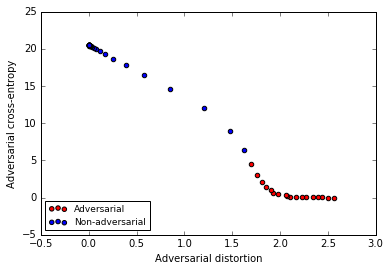

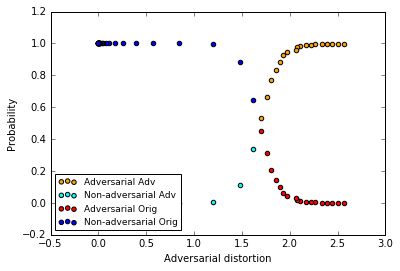

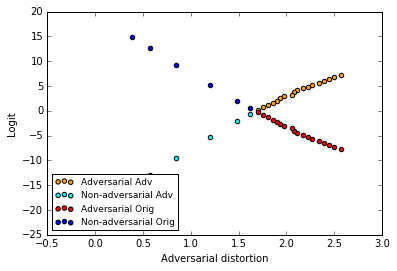

(1, 1, array([[  6.88322865e-09,   9.99997377e-01,   1.57600209e-06,
          8.58260851e-10,   4.84450936e-07,   8.43349446e-10,
          2.43904168e-07,   3.06325006e-07,   6.65352173e-09,
          3.97253454e-12]], dtype=float32))
Img 9795 Adv label 5


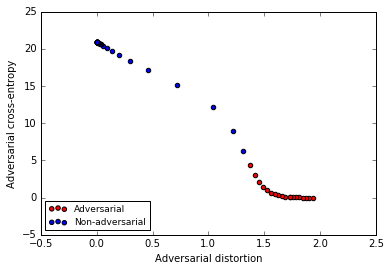

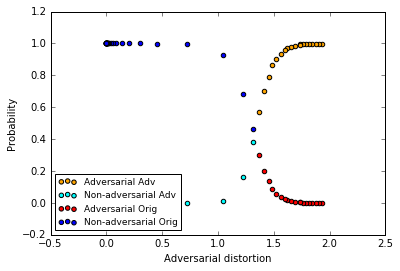

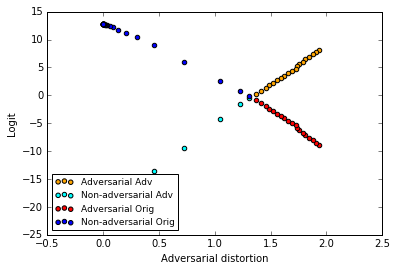

(6, 6, array([[  1.11051328e-10,   1.57356246e-12,   8.27920718e-12,
          2.14590800e-15,   3.80279955e-13,   1.51579971e-10,
          1.00000000e+00,   4.70744596e-16,   8.25028379e-10,
          9.65188253e-18]], dtype=float32))
Img 6406 Adv label 9


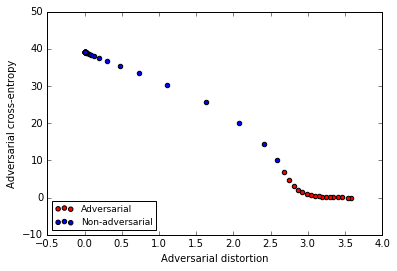

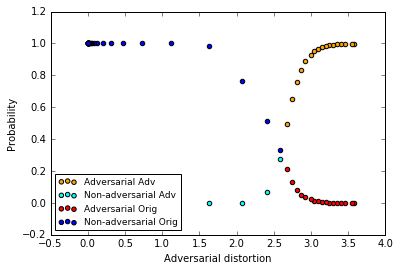

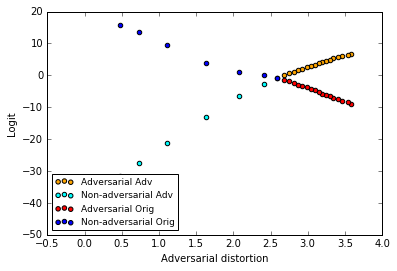

(2, 2, array([[  1.97095854e-10,   1.44329071e-09,   9.99999762e-01,
          1.88629841e-07,   8.67455520e-19,   2.97794016e-14,
          2.73641363e-14,   4.33764811e-08,   9.72747161e-11,
          2.41085546e-15]], dtype=float32))
Img 9820 Adv label 5


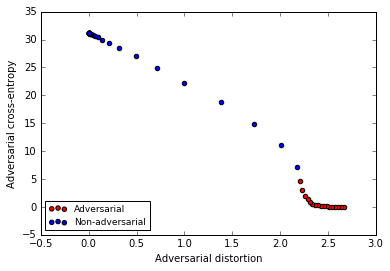

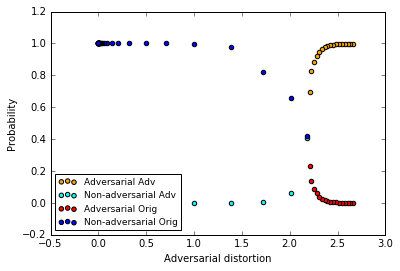

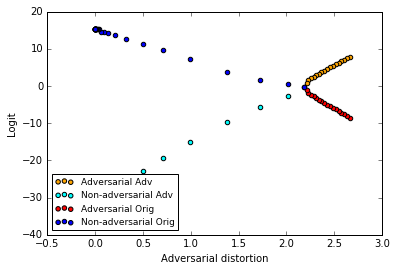

(2, 2, array([[  2.38413263e-14,   6.79185597e-10,   9.99999881e-01,
          7.35718828e-08,   2.31171306e-16,   9.80787283e-13,
          5.60224305e-14,   5.46971635e-10,   2.17773456e-11,
          2.44462096e-17]], dtype=float32))
Img 5502 Adv label 5


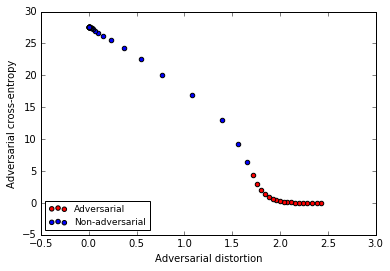

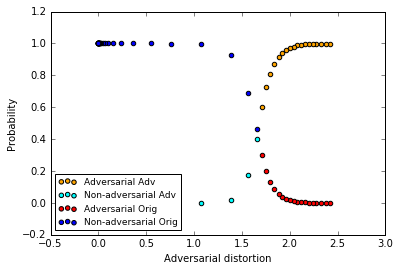

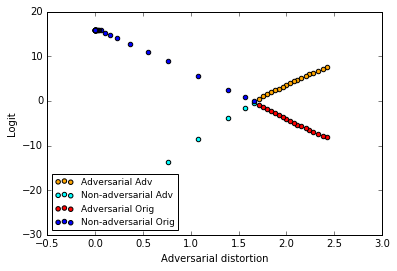

(2, 2, array([[  2.38561371e-09,   8.12788858e-06,   9.99990463e-01,
          1.32681441e-06,   7.86530400e-13,   5.15297735e-11,
          1.85026472e-09,   1.25619763e-07,   2.41710030e-08,
          5.11651051e-13]], dtype=float32))
Img 1658 Adv label 3


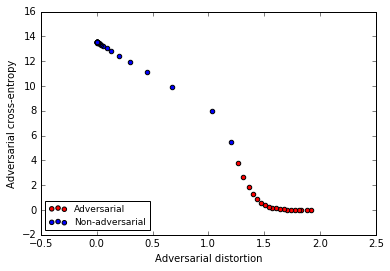

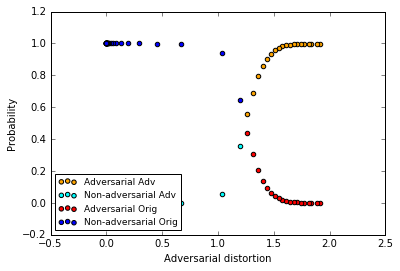

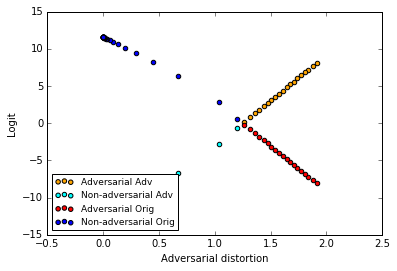

(4, 4, array([[  8.78294833e-12,   3.24420569e-12,   9.15348797e-14,
          7.00925256e-17,   1.00000000e+00,   1.44440222e-12,
          4.89080554e-10,   3.10124912e-11,   1.03319209e-12,
          6.90656516e-12]], dtype=float32))
Img 1529 Adv label 7


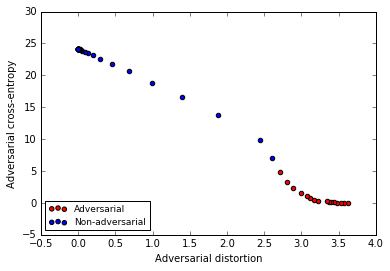

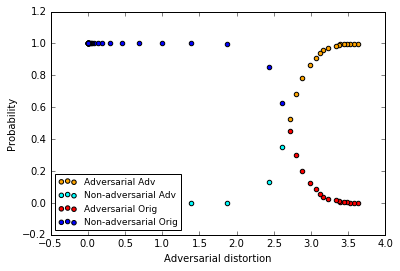

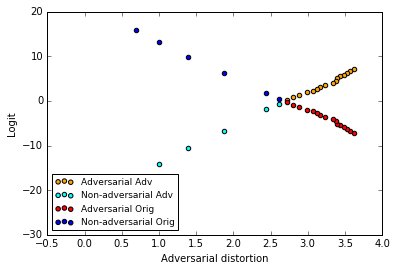

(4, 4, array([[  1.49444429e-10,   2.60169122e-06,   4.43338610e-09,
          2.03429185e-08,   9.99994397e-01,   6.73175474e-11,
          4.60958771e-10,   1.10704306e-07,   2.21360930e-10,
          2.80298718e-06]], dtype=float32))
Img 4826 Adv label 9


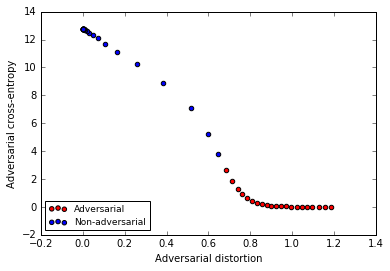

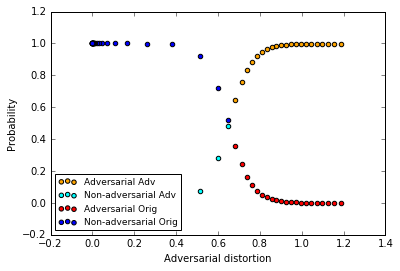

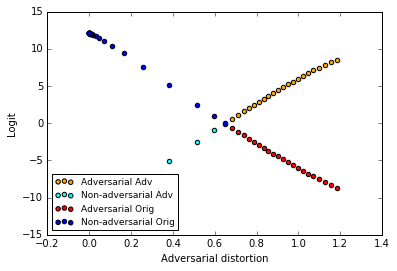

(3, 3, array([[  2.30184165e-17,   3.63835394e-12,   1.09399425e-12,
          1.00000000e+00,   2.15835896e-15,   8.30730831e-11,
          2.31478433e-20,   7.64706969e-14,   1.24958082e-11,
          7.84693110e-09]], dtype=float32))
Img 5700 Adv label 6


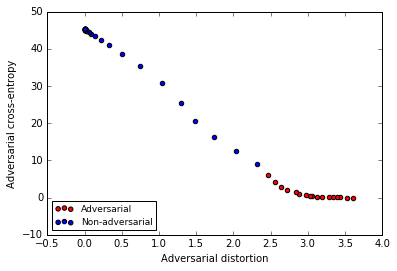

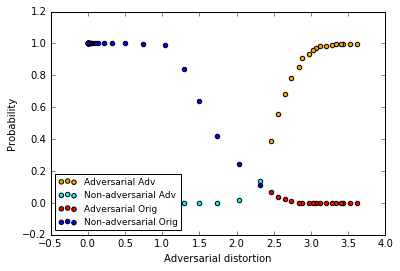

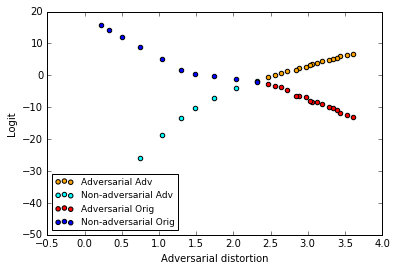

(7, 7, array([[  2.83733814e-10,   2.81017876e-08,   1.05559106e-09,
          1.88041760e-09,   5.00489546e-11,   1.50446364e-10,
          9.08281053e-15,   9.99999881e-01,   2.16987452e-12,
          1.33225839e-07]], dtype=float32))
Img 7584 Adv label 0


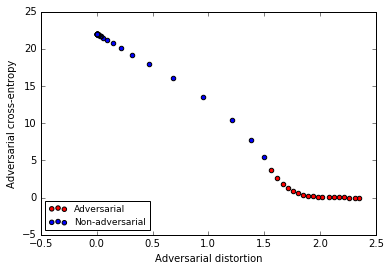

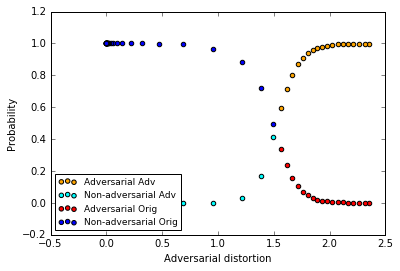

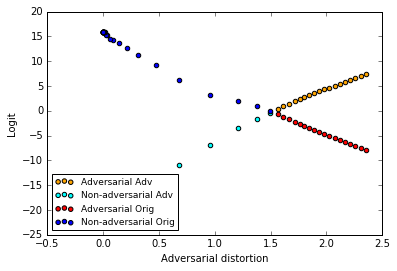

(6, 6, array([[  1.06858771e-08,   1.93292919e-08,   2.68318502e-07,
          7.72075806e-12,   1.00183148e-04,   1.67081410e-07,
          9.99899387e-01,   3.07958214e-10,   4.11892326e-10,
          8.52868817e-12]], dtype=float32))
Img 5916 Adv label 5


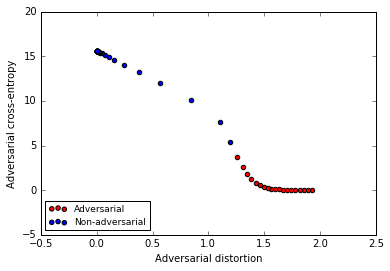

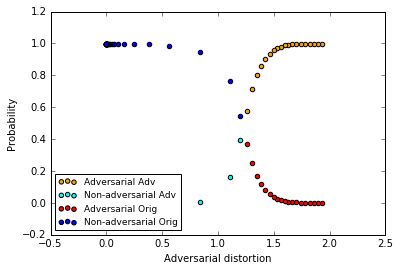

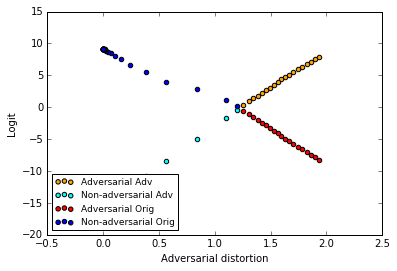

(6, 6, array([[  5.97528194e-10,   9.82061546e-13,   9.61375077e-12,
          4.16576479e-15,   2.29829211e-10,   9.95407534e-10,
          1.00000000e+00,   8.31908115e-16,   2.17723128e-14,
          4.43309558e-15]], dtype=float32))
Img 6707 Adv label 0


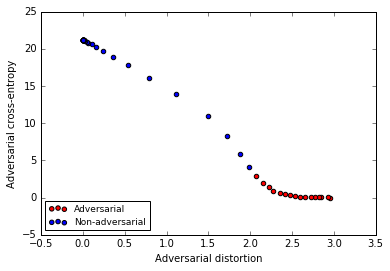

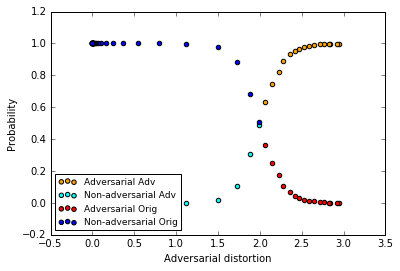

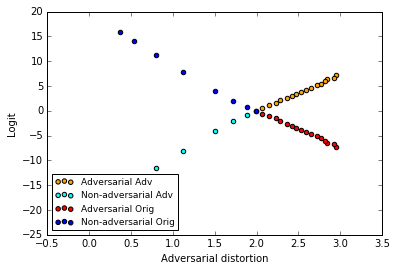

(5, 5, array([[  7.16949344e-09,   5.57438673e-09,   3.21976716e-11,
          5.81172710e-09,   3.33987005e-10,   9.99938726e-01,
          2.26554650e-10,   5.88335970e-05,   1.76768935e-06,
          5.78241952e-07]], dtype=float32))
Img 59 Adv label 3


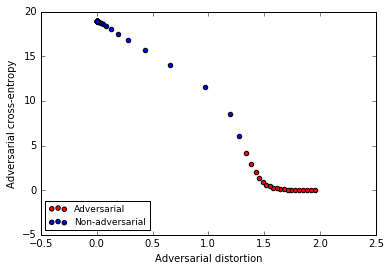

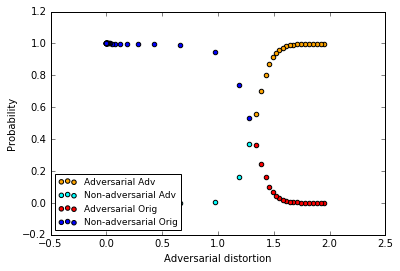

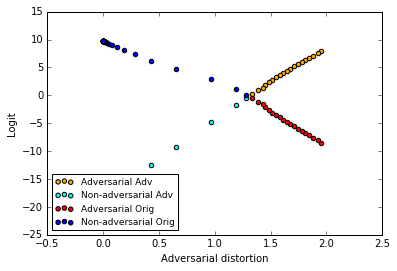

(1, 1, array([[  3.68393727e-12,   9.99999523e-01,   1.83299709e-09,
          5.41181056e-09,   9.31951405e-09,   6.82008006e-10,
          2.70825655e-08,   1.33202548e-07,   4.08987972e-07,
          1.34856865e-11]], dtype=float32))
Img 3014 Adv label 0


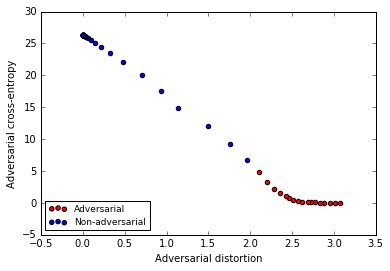

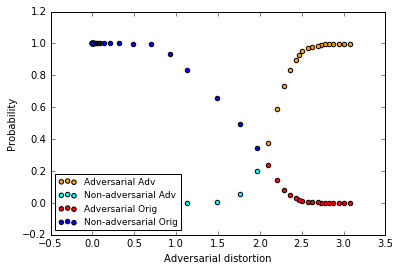

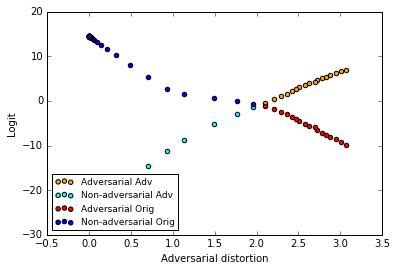

(9, 9, array([[  8.66068189e-11,   2.49832738e-10,   8.65336882e-12,
          9.73943273e-08,   3.05473890e-07,   2.84398749e-09,
          1.21261359e-13,   4.78966613e-05,   5.73566172e-09,
          9.99951720e-01]], dtype=float32))
Img 9767 Adv label 1


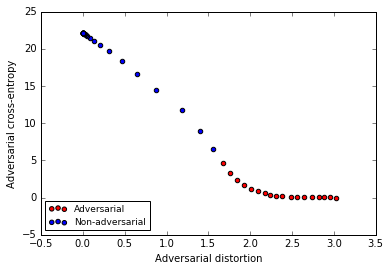

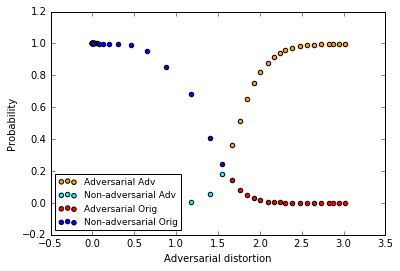

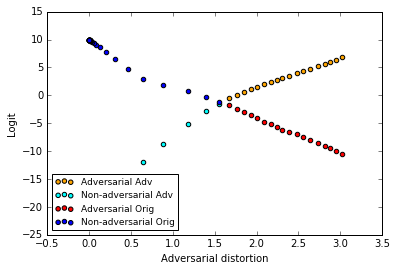

(5, 5, array([[  3.17719958e-14,   8.47511758e-14,   2.04197218e-15,
          4.58417321e-13,   4.00841876e-14,   9.99999762e-01,
          2.51443910e-09,   5.60912799e-15,   2.18712557e-07,
          1.64206981e-10]], dtype=float32))
Img 6146 Adv label 0


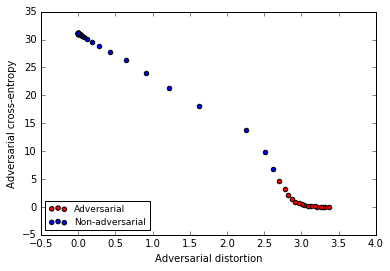

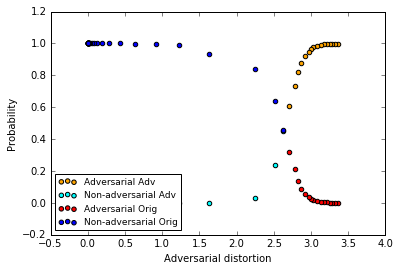

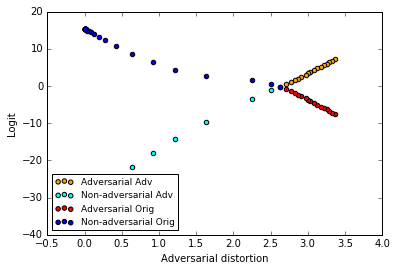

In [15]:
n = 25

adv_norm = []
adv_prob = []
orig_prob = []

for i in range(n):
    an, _, ap, op = orig_adv_dist(plot = True)
    adv_norm.append(an)
    adv_prob.append(ap)
    orig_prob.append(op)
    
adv_norm = np.array(adv_norm)
adv_prob = np.array(adv_prob)
adv_prob_logit = scipy.special.logit(adv_prob)
orig_prob = np.array(orig_prob)
orig_prob_logit = scipy.special.logit(orig_prob)

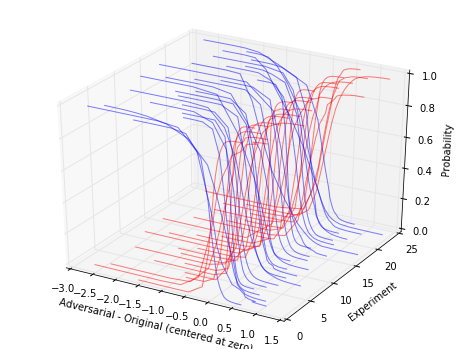

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n):
    intersection = np.argmax((orig_prob[i] - adv_prob[i]) >= 0)
    intersection_x = (adv_norm[i][intersection-1] + adv_norm[i][intersection])/2.0
    intersection_y1 = 0#(adv_prob[i][intersection-1] + adv_prob[i][intersection])/2.0
    intersection_y2 = 0#(orig_prob[i][intersection-1] + orig_prob[i][intersection])/2.0
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), adv_prob[i]-intersection_y1, color = 'r', alpha = 0.5)
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), orig_prob[i]-intersection_y2, color = 'b', alpha = 0.5)

ax.set_xlabel('Adversarial - Original (centered at zero)')
ax.set_ylabel('Experiment')
ax.set_zlabel('Probability')
fig.set_figwidth(8)
fig.set_figheight(6)
plt.show()

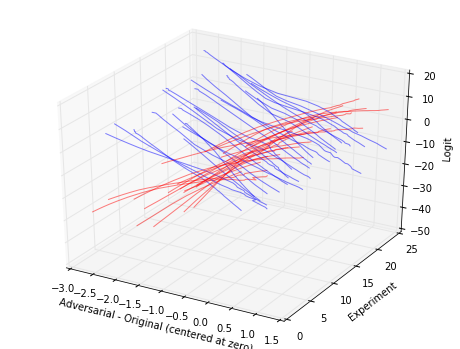

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n):
    intersection = np.argmax((orig_prob_logit[i] - adv_prob_logit[i]) >= 0)
    intersection_x = (adv_norm[i][intersection-1] + adv_norm[i][intersection])/2.0
    intersection_y1 = 0#(adv_prob_logit[i][intersection-1] + adv_prob_logit[i][intersection])/2.0
    intersection_y2 = 0#(orig_prob_logit[i][intersection-1] + orig_prob_logit[i][intersection])/2.0
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), adv_prob_logit[i]-intersection_y1, color = 'r', alpha = 0.5)
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), orig_prob_logit[i]-intersection_y2, color = 'b', alpha = 0.5)

ax.set_xlabel('Adversarial - Original (centered at zero)')
ax.set_ylabel('Experiment')
ax.set_zlabel('Logit')
fig.set_figwidth(8)
fig.set_figheight(6)
plt.show()